In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed
tf.keras.backend.clear_session()
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
from multiprocessing import Pool
import os

## Data Tokenization

In [3]:
data_df = pd.read_csv('/content/drive/MyDrive/seq2seq/data_preprocessed_post_analysis1.csv')

In [4]:
data_df.shape

(16000, 2)

In [5]:
english_text_inp = '<start> ' + data_df['english_text'].astype(str)
english_text_out = data_df['english_text'].astype(str) + ' <end>'

In [6]:
data_df['english_inp'] = english_text_inp
data_df['english_out'] = english_text_out

In [7]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data_df, test_size=0.1, random_state=33)
train, test = train_test_split(train, test_size=0.1)

In [8]:
# we are doing the below step to add '<end>' to the tokenizer dictionary

train.iloc[0]['english_inp'] = train.iloc[0]['english_inp'] + ' <end>'

In [9]:
tknizer_corr = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_corr.fit_on_texts(train['corrupted_text'].values)

tknizer_eng = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
tknizer_eng.fit_on_texts(train['english_inp'].values)

In [10]:
import joblib
joblib.dump(tknizer_corr, '/content/drive/MyDrive/seq2seq/tknizer_corr')
joblib.dump(tknizer_eng,  '/content/drive/MyDrive/seq2seq/tknizer_eng€')

['/content/drive/MyDrive/seq2seq/tknizer_eng€']

In [11]:
vocab_size_eng=len(tknizer_eng.word_index.keys())
print(vocab_size_eng)
vocab_size_corr=len(tknizer_corr.word_index.keys())
print(vocab_size_corr)

2993
20105


## Encoder Decoder with Attention Mechanism

In [12]:
!pip install nlpaug

In [13]:
from nlpaug.util.file.download import DownloadUtil
model_dir = '/content/'
if not os.path.exists('/content/glove.6B'):
  DownloadUtil.download_glove('glove.6B', '/content/')

In [14]:

embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


encoder_embedding_matrix = np.zeros((vocab_size_corr+1, 300))
for word, i in tknizer_corr.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        encoder_embedding_matrix[i] = embedding_vector

decoder_embedding_matrix = np.zeros((vocab_size_eng+1, 300))
for word, i in tknizer_eng.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        decoder_embedding_matrix[i] = embedding_vector

In [15]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        super().__init__()

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length
        self.lstm_size = lstm_size

        self.embedding = Embedding(input_dim=self.inp_vocab_size, output_dim=self.embedding_size, input_length=self.input_length,
                    mask_zero=True, name="embedding_layer_encoder",
                     weights=[encoder_embedding_matrix], trainable=False
                     )
        self.lstm = LSTM(self.lstm_size, return_state=True, return_sequences=True, name="Encoder_LSTM", 
                             activation ='tanh', kernel_regularizer=l2(1e-3)
                             )

    def call(self,input_sequence,states):

        #   This function takes a sequence input and the initial states of the encoder.
        #   Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
        #   returns -- All encoder_outputs, last time steps hidden and cell state

        embedding_layer = self.embedding(input_sequence)

        lstm_output, lstm_state_h, lstm_state_c = self.lstm(embedding_layer)
        
        return lstm_output, lstm_state_h, lstm_state_c

    
    def initialize_states(self,batch_size):
    #   '''
    #   Given a batch size it will return intial hidden state and intial cell state.
    #   If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
    #   '''
        hidden_state = np.zeros((batch_size, self.lstm_size))
        cell_state = np.zeros((batch_size, self.lstm_size))

        return hidden_state, cell_state


In [16]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):
    # Please go through the reference notebook and research paper to complete the scoring functions
    super().__init__()  

    self.scoring_function = scoring_function
    self.att_units = att_units
    
    if self.scoring_function=='dot':
      # Intialize variables needed for Dot score  function here
      pass
    
    if scoring_function == 'general':
      # Intialize variables needed for General score function here
        self.w1 = tf.keras.layers.Dense(self.att_units)

    elif scoring_function == 'concat':
      # Intialize variables needed for Concat score function here
        self.w11 = tf.keras.layers.Dense(self.att_units)
        self.w21 = tf.keras.layers.Dense(self.att_units)
        self.v = tf.keras.layers.Dense(1)
  
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
        # Implement Dot score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=-1)
        score = tf.matmul(encoder_output,decoder_hidden_state)

    elif self.scoring_function == 'general':
        # Implement General score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=-1)
        score = tf.matmul(self.w1(encoder_output), decoder_hidden_state)

    elif self.scoring_function == 'concat':
        # Implement General score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)
        score = self.v(tf.nn.tanh(self.w11(decoder_hidden_state) + self.w21(encoder_output)))

    weights = tf.nn.softmax(score,axis=1)
    context_vector = weights * encoder_output
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, weights

In [17]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):

    super().__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
    self.tar_vocab_size = tar_vocab_size
    self.att_units = att_units
    self.score_fun = score_fun
    self.input_length = input_length
    self.embedding_dim = embedding_dim
    self.dec_units = dec_units

    self.embedding = Embedding(input_dim=self.tar_vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                            mask_zero=True, name="embedding_layer_step_decoder", 
                            weights=[decoder_embedding_matrix], trainable=False
                            )
    
    self.lstm = LSTM(self.dec_units, return_state=True, return_sequences=True, name="One_Step_decoder_LSTM",
                         activation = 'tanh', kernel_regularizer=l2(1e-3)
                         )

    self.attention = Attention(self.score_fun, self.att_units)

    self.dense = Dense(self.tar_vocab_size)


  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    #     One step decoder mechanisim step by step:
    #   A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)

    # print(input_to_decoder.shape)
    embedding_layer = self.embedding(input_to_decoder)


    #   B. Using the encoder_output and decoder hidden state, compute the context vector.
    context_vector,attention_weights = self.attention(state_h, encoder_output)
    context_vector = tf.expand_dims(context_vector, axis=1)

    # print('embedding layer - ',embedding_layer.shape)
    # print('attention - ', attention.shape)

    #   C. Concat the context vector with the step A output
    concat_layer = concatenate(inputs=[embedding_layer, context_vector])
    #   D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
    lstm_out, state_hidden, state_cell = self.lstm(concat_layer, initial_state=[state_h, state_c])
    lstm_out = tf.squeeze(lstm_out, axis=1)
    # context_vector = tf.squeeze(context_vector, axis=1)
    # states = [state_hidden, state_cell]
    #   E. Pass the decoder output to dense layer(vocab size) and store the result into output.
    output = self.dense(lstm_out)
    #   F. Return the states from step D, output from Step E, attention weights from Step -B
    return output, state_hidden, state_cell, attention_weights, context_vector


In [18]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      #Intialize necessary variables and create an object from the class onestepdecoder
        super().__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.onestepdecoder = OneStepDecoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)

        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):


        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        all_outputs = tf.TensorArray(tf.float32, size=tf.shape(input_to_decoder)[1], name='output_arrays')

        #Create a tensor array as shown in the reference notebook
        #Iterate till the length of the decoder input
        for i in range(tf.shape(input_to_decoder)[1]):
            # print(tf.reshape(input_to_decoder[:,i], [-1,1]))
            # print(input_to_decoder[:].shape)
            # Call onestepdecoder for each token in decoder_input
            output, decoder_hidden_state, decoder_cell_state, _, _ = self.onestepdecoder(input_to_decoder[:,i:i+1], encoder_output, decoder_hidden_state, decoder_cell_state)

            # Store the output in tensorarray
            all_outputs = all_outputs.write(i, output)
        
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        # Return the tensor array
        return all_outputs
        
        
    

In [19]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, vocab_encoder_len, vocab_decoder_len, embedding_dim, lstm_size, input_length, score_fun, att_units):
    #Intialize objects from encoder decoder
    super().__init__()
    self.vocab_encoder_size = vocab_encoder_len
    self.vocab_decoder_size = vocab_decoder_len
    self.embedding_dim = embedding_dim
    self. lstm_size = lstm_size
    self. input_length = input_length
    self.socre_fun = score_fun
    self.att_units = att_units
    self.encoder = Encoder(self.vocab_encoder_size, self.embedding_dim , lstm_size,input_length)
    self.decoder = Decoder(self.vocab_decoder_size, self.embedding_dim, input_length, lstm_size ,score_fun ,att_units)

  
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    initial_state=self.encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=self.encoder(data[0],initial_state)


    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    output=self.decoder(data[1],encoder_output, state_h, state_c)
    # return the decoder output
    return output


In [20]:
class Dataset:
    def __init__(self, data, tknizer_corr, tknizer_eng, max_len):
        self.encoder_inps = data['corrupted_text'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_corr = tknizer_corr
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_corr.texts_to_sequences([self.encoder_inps[i]]) # need to pass list of values
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self): # your model.fit_gen requires this function
        return len(self.encoder_inps)

    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.dataset.encoder_inps))


    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        # we are creating data like ([italian, english_inp], english_out) these are already converted into seq
        return tuple([[batch[0],batch[1]],batch[2]])

    def __len__(self):  # your model.fit_gen requires this function
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [21]:
train_dataset = Dataset(train, tknizer_corr, tknizer_eng, 50)
validation_dataset  = Dataset(validation, tknizer_corr, tknizer_eng, 50)

train_dataloader = Dataloder(train_dataset, batch_size=100)
validation_dataloader = Dataloder(validation_dataset, batch_size=100)


print(train_dataloader[0][0][0].shape, train_dataloader[0][0][1].shape, train_dataloader[0][1].shape)

(100, 50) (100, 50) (100, 50)


In [22]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

# Refer https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
def custom_lossfunction(targets,logits):

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    loss_ = loss_object(targets, logits)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [23]:
def learning_rate_scheduler(epoch, learning_rate):
  if epoch % 10 == 0:
    learning_rate = learning_rate * 0.95
    return learning_rate
  else:
    return learning_rate

In [24]:
import datetime
embedding_dim = 300
lstm_size = 300
input_length = 50
score_fun = 'concat'
att_units = 32
batch_size = 100

model = encoder_decoder(vocab_size_corr + 1, vocab_size_eng + 1, embedding_dim, lstm_size, input_length, score_fun, att_units)

optimizer = tf.keras.optimizers.Adam(0.01)

model.compile(optimizer=optimizer,loss=custom_lossfunction)

# log_dir="model_concat1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.compat.v1.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_grads =True)

learningratescheduler = LearningRateScheduler(learning_rate_scheduler)

train_steps=train.shape[0]//100
valid_steps=validation.shape[0]//100

model_history1 = model.fit(x = train_dataloader, steps_per_epoch =train_steps, epochs=30, validation_data=validation_dataloader, 
              validation_steps = valid_steps,
              callbacks =[
                      tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_loss', factor=0.2, patience=1),
                    #   tensorboard_callback,
                      learningratescheduler
          ]
              )


model.summary()

Epoch 1/30
129/129 [==============================] - 136s 969ms/step - loss: 1.7723 - val_loss: 1.5756
Epoch 2/30
129/129 [==============================] - 125s 970ms/step - loss: 1.4256 - val_loss: 1.3469
Epoch 3/30
129/129 [==============================] - 126s 977ms/step - loss: 1.1345 - val_loss: 1.0638
Epoch 4/30
129/129 [==============================] - 126s 976ms/step - loss: 0.8804 - val_loss: 0.8828
Epoch 5/30
129/129 [==============================] - 124s 963ms/step - loss: 0.7117 - val_loss: 0.7548
Epoch 6/30
129/129 [==============================] - 123s 957ms/step - loss: 0.6110 - val_loss: 0.6664
Epoch 7/30
129/129 [==============================] - 124s 964ms/step - loss: 0.5194 - val_loss: 0.6040
Epoch 8/30
129/129 [==============================] - 124s 963ms/step - loss: 0.4696 - val_loss: 0.5588
Epoch 9/30
129/129 [==============================] - 124s 959ms/step - loss: 0.4270 - val_loss: 0.5544
Epoch 10/30
129/129 [==============================] - 122s 948m

In [25]:
model.save_weights('content/drive/MyDrive/seq2seq/simple_model')

In [26]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  6753000   
_________________________________________________________________
decoder (Decoder)            multiple                  2899891   
Total params: 9,652,891
Trainable params: 2,722,891
Non-trainable params: 6,930,000
_________________________________________________________________


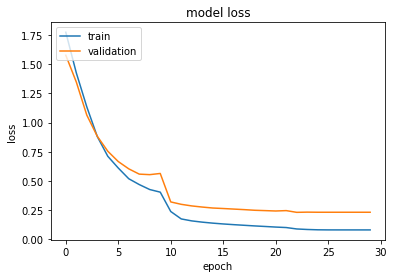

In [27]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(model_history1.history['loss'])
plt.plot(model_history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [28]:
#  Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def predict(input_sentence, target, model, plot_attention_flag):

    
    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_h,input_c, attention_weights, _ = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''

    attention_plot = np.zeros((50, 50))
    inp_seq = tknizer_corr.texts_to_sequences([input_sentence])
    inp_seq = pad_sequences(inp_seq,padding='post',maxlen=50)

    encoder = Encoder(inp_vocab_size=vocab_size_corr, embedding_size=100, lstm_size=256, input_length=50)
    states = encoder.initialize_states(32)

    en_outputs,state_h , state_c = model.layers[0](tf.constant(inp_seq), states)
    cur_vec = tf.constant([[tknizer_eng.word_index['<start>']]])
    pred = []
    
    #Here 50 is the max_length of the sequence
    for i in range(50):
        infe_output, state_h, state_c, attention_weights, _ = model.layers[1].layers[0](cur_vec,en_outputs,state_h,state_c)
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()
        cur_vec = np.reshape(np.argmax(infe_output), (1, 1))
        if cur_vec[0][0]:
          pred.append(tknizer_eng.index_word[cur_vec[0][0]])
        else: 
          continue
        if(pred[-1]=='<end>'):
            break
    translated_sentence = ' '.join(pred)
    attention_plot = attention_plot[:len(translated_sentence.split(' ')),
                                    :len(input_sentence.split(' '))]

    if plot_attention_flag:
        plot_attention(attention_plot, input_sentence.split(' '), translated_sentence.split(' '))    

    return translated_sentence

In [30]:
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
bleu_score = list()
random_numbers = np.random.randint(1, len(test), 100)
for i in (random_numbers):

    actual_ = test.iloc[i]['english_text']
    pred_ = predict(test.iloc[i]['corrupted_text'], actual_, model, plot_attention_flag=False)

    reference = [actual_.split()]
    candidate = pred_.split()[:-1]

    score = sentence_bleu(reference, candidate)
    bleu_score.append(score)

    print('actual  :', actual_)
    print('predicted:', pred_)
    print('bleu score:', score)
    print()
    print('-' * 120)


actual  : yeah said going with wawa still must take mrt sigh
predicted: yes jos called that like raining going to see my handphone girl <end>
bleu score: 0.537284965911771

------------------------------------------------------------------------------------------------------------------------
actual  : crazy still buy wine at home got a bottle of wine already
predicted: crazy still buy wine at home got a bottle of wine <end>
bleu score: 0.9131007162822624

------------------------------------------------------------------------------------------------------------------------
actual  : haha okay how late i go to buy tickets first
predicted: haha okay so late i go to buy tickets first <end>
bleu score: 0.7071067811865475

------------------------------------------------------------------------------------------------------------------------
actual  : where are you all
predicted: where are you all <end>
bleu score: 1.0

---------------------------------------------------------------------

In [31]:
predicted_sentences = list()
bleu_score = list()
for i in tqdm(data_df.iterrows(), total=len(data_df)):

    actual_ = data_df.iloc[i[0]]['english_text']
    pred_ = predict(data_df.iloc[i[0]]['corrupted_text'], actual_, model, plot_attention_flag=False)

    reference = [actual_.split()]
    candidate = pred_.split()[:-1]

    score = sentence_bleu(reference, candidate)
    bleu_score.append(score)
    predicted_sentences.append(' '.join(candidate))


100%|██████████| 16000/16000 [1:12:32<00:00,  3.68it/s]


In [32]:
data = data_df.copy()

In [33]:
data.head(2)

,corrupted_text,english_text,english_inp,english_out
0,yaep you reaching we oredrde some durian pastr...,yeap you reaching we ordered some durian pastr...,<start> yeap you reaching we ordered some duri...,yeap you reaching we ordered some durian pastr...
1,never mind this one it s for aostkalia but i w...,never mind this one it is for australia but i ...,<start> never mind this one it is for australi...,never mind this one it is for australia but i ...


In [34]:
data['predicted_sentences'] = predicted_sentences
data['bleu_score'] = bleu_score

In [35]:
data.head(2)

,corrupted_text,english_text,english_inp,english_out,predicted_sentences,bleu_score
0,yaep you reaching we oredrde some durian pastr...,yeap you reaching we ordered some durian pastr...,<start> yeap you reaching we ordered some duri...,yeap you reaching we ordered some durian pastr...,have you finished any exercise yet what is lik...,0.547518
1,never mind this one it s for aostkalia but i w...,never mind this one it is for australia but i ...,<start> never mind this one it is for australi...,never mind this one it is for australia but i ...,never mind this one it is for australia but i ...,1.000000


In [36]:
# saving the file to disk
# commenting the below code so to change data whenever needed
data.to_csv('/content/drive/MyDrive/seq2seq/data_score_post_analysis1.csv', index=False)

In [37]:
test.reset_index(inplace=True)

In [38]:
predicted_sentences = list()
bleu_score = list()
for i in tqdm(test.iterrows(), total=len(test)):

    actual_ = test.iloc[i[0]]['english_text']
    pred_ = predict(test.iloc[i[0]]['corrupted_text'], actual_, model, plot_attention_flag=False)

    reference = [actual_.split()]
    candidate = pred_.split()[:-1]

    score = sentence_bleu(reference, candidate)
    bleu_score.append(score)
    predicted_sentences.append(' '.join(candidate))


100%|██████████| 1440/1440 [06:07<00:00,  3.91it/s]


In [39]:
test_data = test.copy()

In [40]:
test_data.head(2)

,index,corrupted_text,english_text,english_inp,english_out
0,12346,yun you knwo the tsep by stpe guied obok we wr...,yun you know the step by step guide book we we...,<start> yun you know the step by step guide bo...,yun you know the step by step guide book we we...
1,14926,hii are you girl nor boy,hi are you girl or boy,<start> hi are you girl or boy,hi are you girl or boy <end>


In [41]:
test_data['predicted_sentences'] = predicted_sentences
test_data['bleu_score'] = bleu_score

In [42]:
test_data.head(2)

,index,corrupted_text,english_text,english_inp,english_out,predicted_sentences,bleu_score
0,12346,yun you knwo the tsep by stpe guied obok we wr...,yun you know the step by step guide book we we...,<start> yun you know the step by step guide bo...,yun you know the step by step guide book we we...,yun you know the step by step guide book we we...,0.881774
1,14926,hii are you girl nor boy,hi are you girl or boy,<start> hi are you girl or boy,hi are you girl or boy <end>,what are you up tonight,0.460406


In [43]:
# saving the file to disk
# commenting the below code so to change data whenever needed
test_data.to_csv('/content/drive/MyDrive/seq2seq/test_data_score_post_analysis1.csv', index=False)